<a href="https://colab.research.google.com/github/azhara001/Fabric-Composition-Extraction/blob/main/Inference_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Script* File for Model Inference on the Test Set

In [5]:
# # importing necessary HF packages -> if in google-colab, please uncomment the following lines and run them followed by restarting the kernel
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install torchview # for visualizing the transformer architecture

In [6]:
# mounting Google Drive (only necessary because I want to import an image from my local directory as a test image) -> an image would come directly
# from the front-end in our case project case.
# Anyone testing the model on their custom image should import it as a PIL image as shown below
# mounting GoogleDrive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone_Repo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Capstone_Repo


In [2]:
# connecting to huggingface and running huggingface-cli login
from huggingface_hub import notebook_login

# enter the following token:
notebook_login()

# import our dataset (uploaded to huggingface hub)
from datasets import load_dataset
#dataset = load_dataset("azhara001/Fabric-Composition-Tags-v2")

image_size = [1280, 960] # encoder image size
max_length = 768 # max length to be used by default in the model.generate method

In [8]:
# importing the loaded pre-trained model from HF Hub -> all you need to run are the three lines of code to import model from HF
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
# path = "azhara001/donut-base-demo-final_v23e-05_Adam" # hugging face model link
path = "azhara001/donut-base-demo-final_v23e-05_AdamW"
processor = DonutProcessor.from_pretrained(path)
model = VisionEncoderDecoderModel.from_pretrained(path)

preprocessor_config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.99k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [9]:
# importing image using PIL
from PIL import Image
from IPython.display import display
from IPython.display import Image as IPImage
rgb_to_gray = False
downsample = False

## add an image in your local dir to be tested. We experimented with the following images.
image_path = '6553.jpg'

# reading the image using PIL
if rgb_to_gray:
  im = Image.open(image_path).convert('L')
else:
  im = Image.open(image_path)

im = im.resize((1280,960)) # resizing image to the processor image_size based on our custom configuration

In [10]:
im1 = im.rotate(180) # flipping the image to test for robustness

In [11]:
# Preprocessing steps of the input image
# if we are getting a .jpg image from front-end then only execute the below lines
## ______________________ Preprocessing of input image _________________________

if im.size[0] < im.size[1]: # rotate image if in landscape format
    im = im.transpose(Image.ROTATE_90)

image_size = [1280, 960] # starting with the custom image size
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

pixel_values = processor(im, return_tensors="pt").pixel_values
pixel_values1 = processor(im1, return_tensors="pt").pixel_values
print(pixel_values.shape)

task_prompt = "<s_demo_v1>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]


torch.Size([1, 3, 1280, 960])


In [13]:
## calling the model and doing an inference
from torchview import draw_graph
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# inference on image
outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

# visualize the architecture backbone using torchview
input_data = {'pixel_values':pixel_values, 'decoder_input_ids':decoder_input_ids}
model_graph = draw_graph(model, input_data = input_data,roll=True,save_graph=True)

# inference on flipped image to check for model robustness
outputs1 = model.generate(pixel_values1.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

input_data = {'pixel_values':pixel_values1, 'decoder_input_ids':decoder_input_ids}
model_graph = draw_graph(model, input_data = input_data,roll=True,save_graph=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


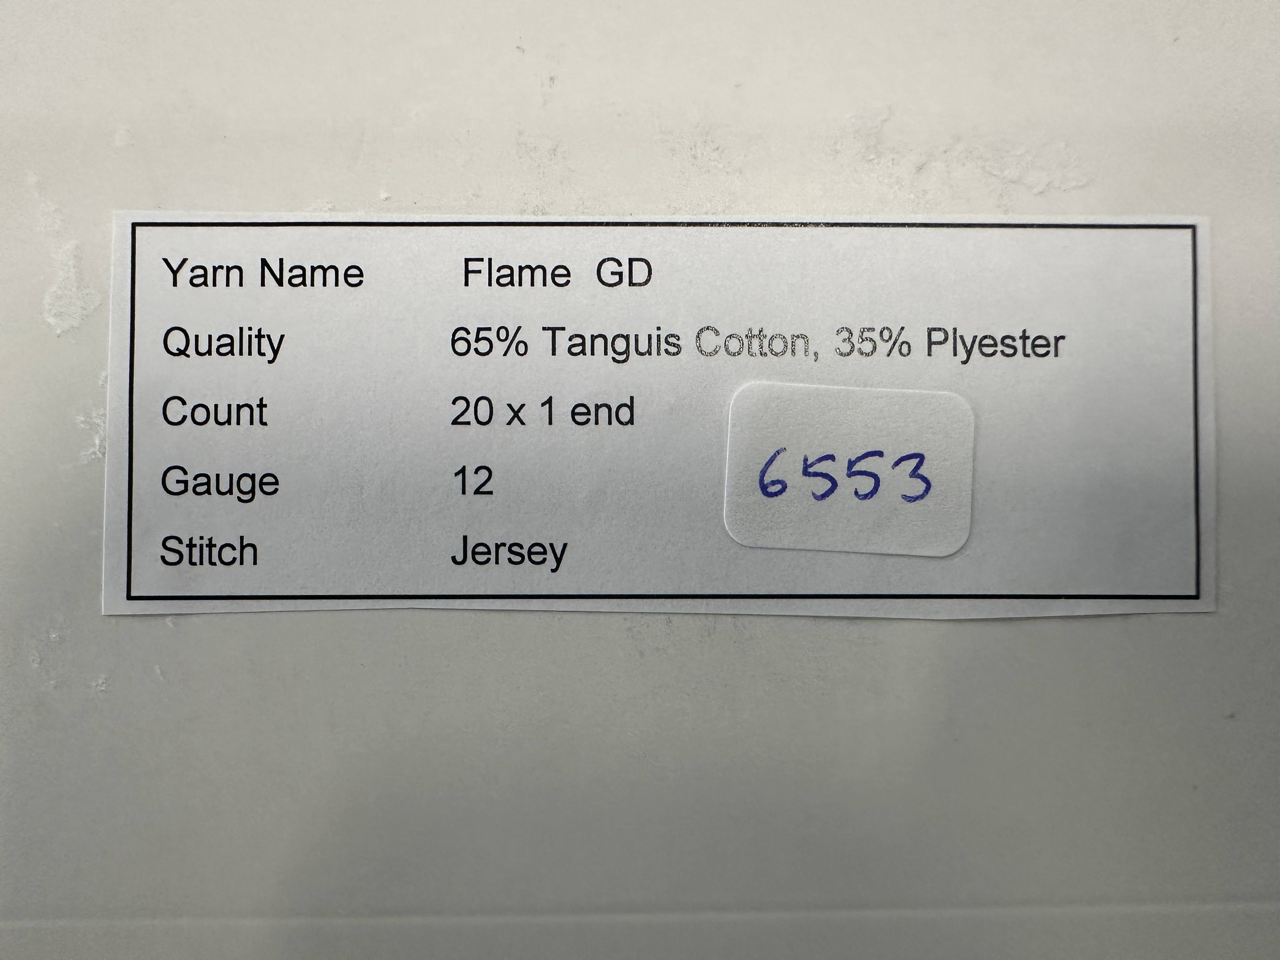

In [16]:
# viewing the straight image
im

In [15]:
## ______________________ Postprocessing of input image _________________________
import re
sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
processor.token2json(sequence)

{'sample_id': '6553.0',
 'composition': {'polyester': '35.0',
  'elastane': 'None',
  'rayon': 'None',
  'cotton': '65.0',
  'tencel': 'None',
  'nylon': 'None',
  'viscose': 'None',
  'modal': 'None',
  'nylon_6': 'None',
  'nylon_66': 'None',
  'cupro': 'None',
  'micromodal': 'None'}}

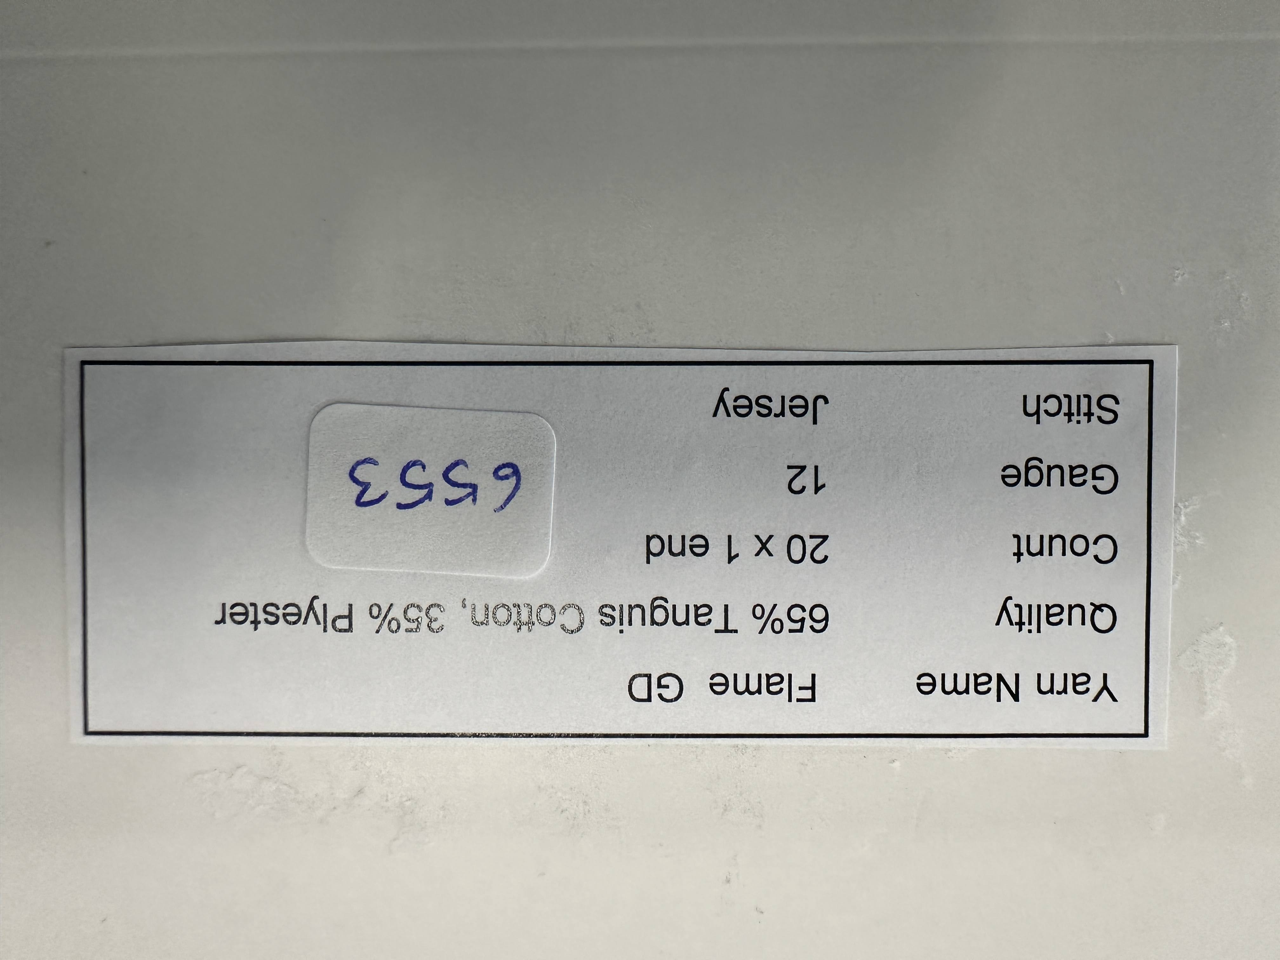

In [14]:
# viewing the flipped image
im1

In [17]:
## ______________________ Postprocessing of input image _________________________
import re
sequence1 = processor.batch_decode(outputs1.sequences)[0]
sequence1 = sequence1.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence1 = re.sub(r"<.*?>", "", sequence1, count=1).strip()  # remove first task start token
processor.token2json(sequence1)

{'sample_id': '6559.0',
 'composition': {'polyester': 'None',
  'elastane': 'None',
  'rayon': 'None',
  'cotton': '99.0',
  'tencel': 'None',
  'nylon': 'None',
  'viscose': 'None',
  'modal': 'None',
  'nylon_6': 'None',
  'nylon_66': 'None',
  'cupro': 'None',
  'micromodal': 'None'}}

As evident from the above results, the model is unable to predict the result correctly which makes intuitive sense given the model is trained to extract text from the image. It is interesting to note how the model did it's best to estimate sample_id by looking at the relevant part of the image and predicts 6559. Next, it would be helpful to try and mask certain parts of the image and see what the model predicts as shown below

### Masking regions of input image and assessing model performance

In [29]:
im_pixels = im.load()
width, height = im.size
for x in range(width):
    for y in range(height):
        if x > 700 and x < 1000: # values chosen at random to mask sample_id
            if y > 400 and y < 500: # values chosen at random to mask sample_id
                im_pixels[x,y] = (0,0,0)


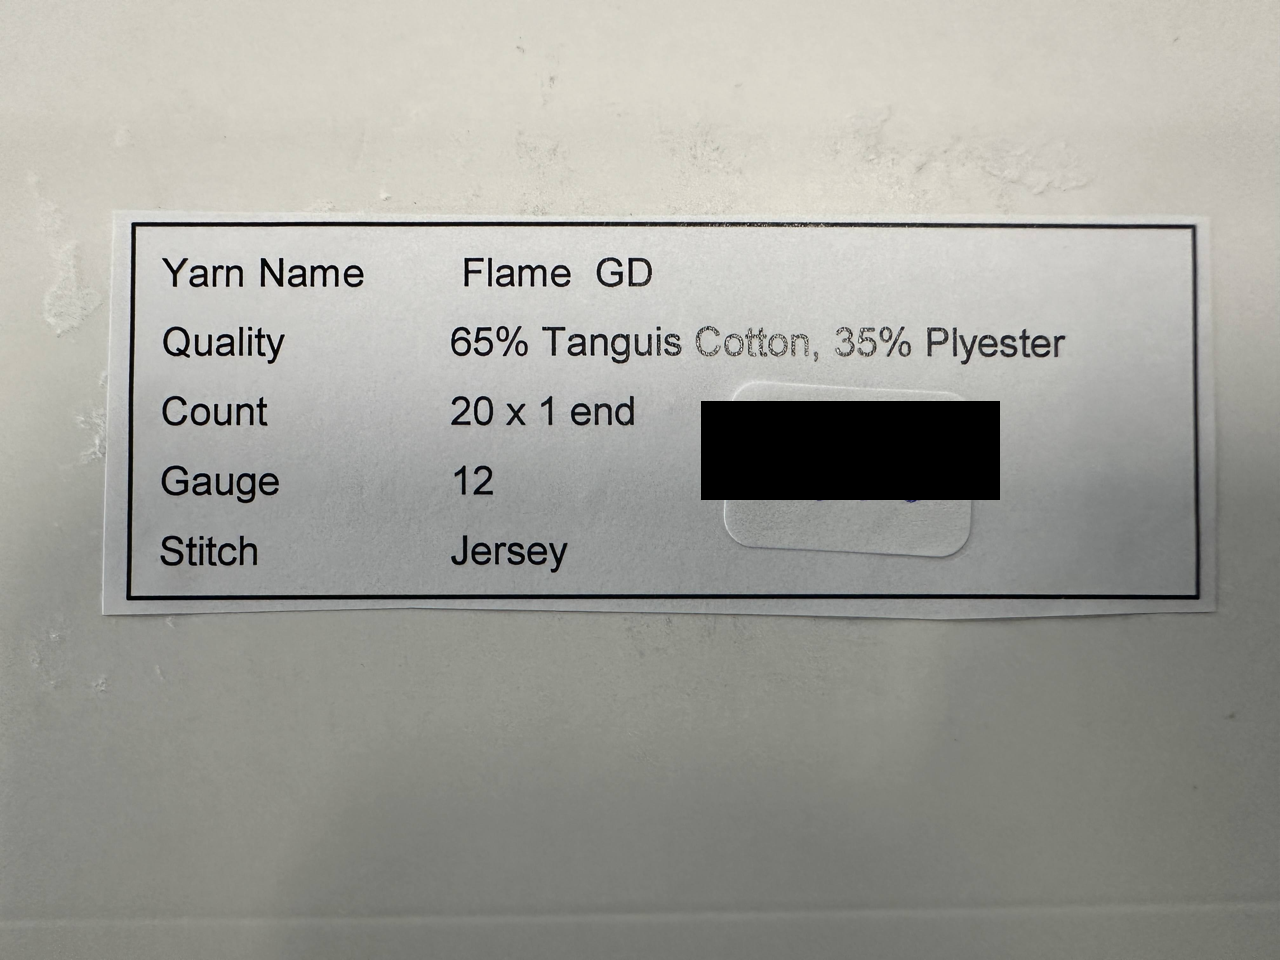

In [30]:
im

In [31]:
# performing inference on the masked image
pixel_values_masked = processor(im, return_tensors="pt").pixel_values
# inference on image
outputs_masked = model.generate(pixel_values_masked.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

sequence = processor.batch_decode(outputs_masked.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
processor.token2json(sequence)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


{'sample_id': '65.0',
 'composition': {'polyester': '35.0',
  'elastane': 'None',
  'rayon': 'None',
  'cotton': '65.0',
  'tencel': 'None',
  'nylon': 'None',
  'viscose': 'None',
  'modal': 'None',
  'nylon_6': 'None',
  'nylon_66': 'None',
  'cupro': 'None',
  'micromodal': 'None'}}

#### Analysis: The model shows impressive performance in correctly predicting the fabric composition which indicates that it has learnt how to identify the tag composition based on the text in the image. However, the model mistakes sample_id with 65 as well which indicates that the model has mistaken the cotton composition with the sample id rather than predicting None because sample_id serves as a primary key and no None values were present for them in the training data

In [65]:
# Masking Cotton Composition Value
im = Image.open(image_path)
im = im.resize((1280,960))
#im_og = im.copy()

im_pixels = im.load()
width, height = im.size
for x in range(width):
    for y in range(height):
        if x > 420 and x < 1100: # values chosen at random to mask sample_id
            if y > 300 and y < 400: # values chosen at random to mask sample_id
                im_pixels[x,y] = (0,0,0)
            if x > 750 and x < 1100:
                if y > 400 and y < 500:
                    im_pixels[x,y] = (0,0,0)


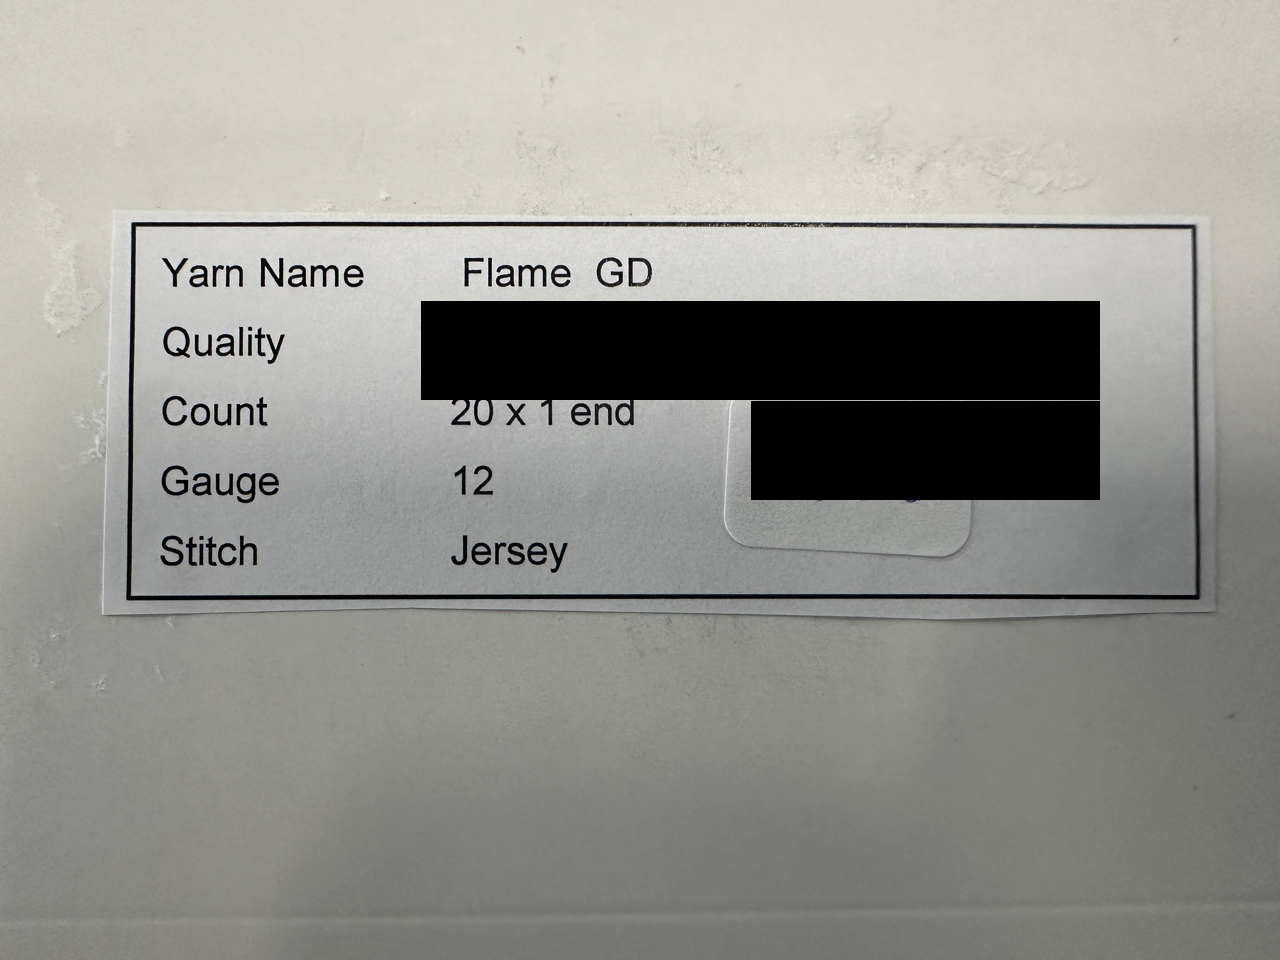

In [66]:
im

In [67]:
# Performing Inference:
# performing inference on the masked image
pixel_values_masked = processor(im, return_tensors="pt").pixel_values
# inference on image
outputs_masked = model.generate(pixel_values_masked.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

sequence = processor.batch_decode(outputs_masked.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
processor.token2json(sequence)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


{'sample_id': '8071.0',
 'composition': {'polyester': 'None',
  'elastane': 'None',
  'rayon': 'None',
  'cotton': '100.0',
  'tencel': 'None',
  'nylon': 'None',
  'viscose': 'None',
  'modal': 'None',
  'nylon_6': 'None',
  'nylon_66': 'None',
  'cupro': 'None',
  'micromodal': 'None'}}

### This is where we have confused the model into making an inference. Since the test set images follow the same distribution as the train images, it seems that the model has learnt a geospatial structure within an image. For future work, we would work on considering the last hidden states of the encoder as well as decoder to understand how is the model attending to the pixels and decoder generated tokens